In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklift.datasets import fetch_x5

# Получение датасета

In [2]:
dataset = fetch_x5()

data = dataset.data

# Данные обо всех клиентах
clients = data.clients
# Клиенты для обучения
train = data.train           
# Информация о покупках
purchases = data.purchases

# Тритмент
treatement = dataset.treatment
# Целевая переменная
target = dataset.target

In [3]:
# Информация о клиентах
df_clients = pd.concat([train, treatement, target], axis=1)
df_clients = pd.merge(df_clients, clients, left_on='client_id', right_on='client_id')

In [4]:
df_clients

,client_id,treatment_flg,target,first_issue_date,first_redeem_date,age,gender
0,000012768d,0,1,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U
1,000036f903,1,1,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F
2,00010925a5,1,1,2018-07-24 16:21:29,2018-09-14 16:12:49,83,U
3,0001f552b0,1,1,2017-06-30 19:20:38,2018-08-28 12:59:45,33,F
4,00020e7b18,1,1,2017-11-27 11:41:45,2018-01-10 17:50:05,73,U
...,...,...,...,...,...,...,...
200034,fffe0abb97,0,0,2017-11-27 08:56:54,2018-02-11 09:26:08,35,F
200035,fffe0ed719,0,1,2017-09-15 08:53:24,2017-12-12 14:50:12,69,U
200036,fffea1204c,0,1,2018-01-31 16:59:37,2018-03-12 17:02:27,73,F
200037,fffeca6d22,1,0,2017-12-28 11:56:13,NaN,77,F


In [5]:
purchases

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
0,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,9a80204f78,2.0,80.0,NaN
1,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,da89ebd374,1.0,65.0,NaN
2,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,0a95e1151d,1.0,24.0,NaN
3,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,4055b15e4a,2.0,50.0,NaN
4,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,a685f1916b,1.0,22.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45786563,fffff6ce77,48f6d115ce,2019-03-15 17:47:02,6.7,0.0,0.0,0.0,676.0,5ec64bdccb,24d5a54f42,1.0,164.0,NaN
45786564,fffff6ce77,48f6d115ce,2019-03-15 17:47:02,6.7,0.0,0.0,0.0,676.0,5ec64bdccb,7427d0830d,1.0,134.0,NaN
45786565,fffff6ce77,48f6d115ce,2019-03-15 17:47:02,6.7,0.0,0.0,0.0,676.0,5ec64bdccb,6c547c2ca8,1.0,60.0,NaN
45786566,fffff6ce77,48f6d115ce,2019-03-15 17:47:02,6.7,0.0,0.0,0.0,676.0,5ec64bdccb,d04e7a8338,1.0,48.0,NaN


# Проверка на пропуски

In [6]:
df_clients.isna().sum()

client_id                0
treatment_flg            0
target                   0
first_issue_date         0
first_redeem_date    17546
age                      0
gender                   0
dtype: int64

Пропуски есть только в `first_redeem_date`. Они обозначают, что событие `redeem` никогда не произошло. Их заполнять не надо.

In [7]:
purchases.isna().sum()

client_id                         0
transaction_id                    0
transaction_datetime              0
regular_points_received           0
express_points_received           0
regular_points_spent              0
express_points_spent              0
purchase_sum                      0
store_id                          0
product_id                        0
product_quantity                  0
trn_sum_from_iss                  0
trn_sum_from_red           42743212
dtype: int64

Пропуски есть только в `trn_sum_from_red`, что обозначает стоимость товара до применения баллов. Равно `NaN` там, где человек не применил баллы. Можно восстановить по значению `trn_sum_from_iss` (стоимость товара после применения баллов).

In [8]:
purchases['trn_sum_from_red'] = purchases['trn_sum_from_red'].fillna(purchases['trn_sum_from_iss'])

In [9]:
# Преобразование значение потраченных баллов из отрицательных в положительные (для удобства)
purchases['regular_points_spent'] = purchases['regular_points_spent'].abs()
purchases['express_points_spent'] = purchases['express_points_spent'].abs()

In [10]:
purchases.isna().sum()

client_id                  0
transaction_id             0
transaction_datetime       0
regular_points_received    0
express_points_received    0
regular_points_spent       0
express_points_spent       0
purchase_sum               0
store_id                   0
product_id                 0
product_quantity           0
trn_sum_from_iss           0
trn_sum_from_red           0
dtype: int64

Теперь пропусков нет.

# Распределение таргета

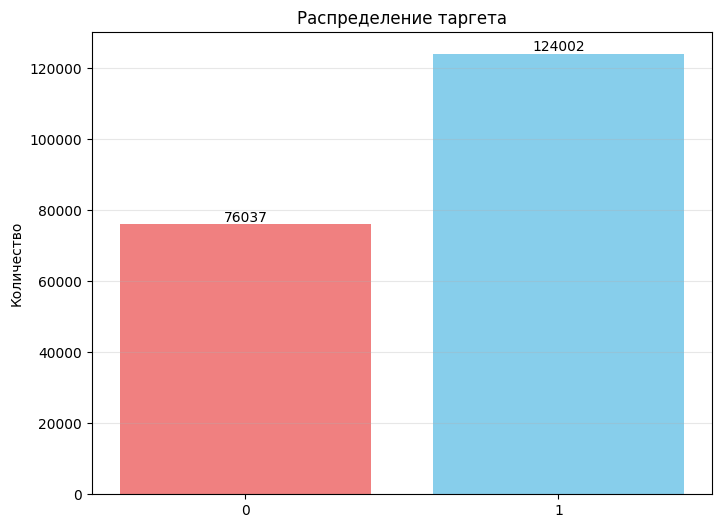

In [11]:
# Подсчет частот
value_counts = target.value_counts().sort_index()

plt.figure(figsize=(8, 6))
plt.bar(value_counts.index, value_counts.values, color=['lightcoral', 'skyblue'])
plt.ylabel('Количество')
plt.title('Распределение таргета')
plt.xticks([0, 1], ['0', '1'])
plt.grid(axis='y', alpha=0.3)

# Добавление подписей с значениями
for i, v in enumerate(value_counts.values):
    plt.text(i, v + 1, str(v), ha='center', va='bottom')

plt.show()

# Feature engineering

In [12]:
class BehavioralFeatureGenerator:
    """
    Класс для генерации агрегированных поведенческих признаков
    на основе транзакционных данных (таблица purchases).
    """
    def __init__(self, purchases_df):
        self.df = purchases_df.copy()

    # Получить уникальные транзакции (без дублирования по product_id)
    def _get_unique_transactions(self):
        cols_to_keep = ['client_id', 'transaction_id', 'transaction_datetime', 
                       'regular_points_received', 'express_points_received',
                       'regular_points_spent', 'express_points_spent', 
                       'purchase_sum', 'store_id']
        
        return self.df[cols_to_keep].drop_duplicates('transaction_id')

    # Получить данные на уровне конкретных продуктов
    def _get_product_level_data(self):
        product_cols = ['client_id', 'transaction_id', 'product_id', 
                       'product_quantity', 'trn_sum_from_iss', 'trn_sum_from_red']
        return self.df[product_cols]

    # Генерация всех фич
    def generate_features(self):
        features = {}
        
        # Базовые фичи по транзакциям
        features.update(self._transaction_features())
        
        # Фичи по баллам
        features.update(self._points_features())
        
        # Фичи по продуктам
        features.update(self._product_features())
        
        # Временные фичи
        features.update(self._time_features())
        
        # Фичи по магазинам
        features.update(self._store_features())
        
        return pd.DataFrame(features)

    # Фичи по транзакциям
    def _transaction_features(self):
        trans_df = self._get_unique_transactions()
        client_trans = trans_df.groupby('client_id')
        
        features = {
            'total_transactions': client_trans.size(),
            'total_purchase_sum': client_trans['purchase_sum'].sum(),
            'avg_transaction_amount': client_trans['purchase_sum'].mean(),
            'std_transaction_amount': client_trans['purchase_sum'].std(),
            'max_transaction_amount': client_trans['purchase_sum'].max(),
            'min_transaction_amount': client_trans['purchase_sum'].min(),
        }
        
        # Квантили
        for q in [0.25, 0.5, 0.75]:
            features[f'transaction_amount_q{q}'] = client_trans['purchase_sum'].quantile(q)
        
        return features

    # Фичи по баллам
    def _points_features(self):
        trans_df = self._get_unique_transactions()
        client_trans = trans_df.groupby('client_id')
        
        features = {
            'total_regular_points_received': client_trans['regular_points_received'].sum(),
            'total_express_points_received': client_trans['express_points_received'].sum(),
            'total_regular_points_spent': client_trans['regular_points_spent'].sum(),
            'total_express_points_spent': client_trans['express_points_spent'].sum(),
            'avg_regular_points_per_transaction': client_trans['regular_points_received'].mean(),
            'avg_express_points_per_transaction': client_trans['express_points_received'].mean(),
            'points_earned_to_spent_ratio': (client_trans['regular_points_received'].sum() + 
                                           client_trans['express_points_received'].sum()) / 
                                          (client_trans['regular_points_spent'].sum() + 
                                           client_trans['express_points_spent'].sum() + 1)  # +1 чтобы избежать деления на 0
        }
        
        return features

    # Фичи по продуктам
    def _product_features(self):
        product_df = self._get_product_level_data()
        client_products = product_df.groupby('client_id')
        
        features = {
            'total_products_purchased': client_products['product_quantity'].sum(),
            'unique_products_count': client_products['product_id'].nunique(),
            'total_trn_sum_from_iss': client_products['trn_sum_from_iss'].sum(),
            'total_trn_sum_from_red': client_products['trn_sum_from_red'].sum(),
            'avg_product_quantity': client_products['product_quantity'].mean(),
        }
        
        return features

    # Временные фичи
    def _time_features(self):
        trans_df = self._get_unique_transactions()
        trans_df['transaction_datetime'] = pd.to_datetime(trans_df['transaction_datetime'])
        
        client_trans = trans_df.groupby('client_id')
        
        features = {
            'first_transaction_date': client_trans['transaction_datetime'].min(),
            'last_transaction_date': client_trans['transaction_datetime'].max(),
            'transaction_period_days': (client_trans['transaction_datetime'].max() - 
                                      client_trans['transaction_datetime'].min()).dt.days,
        }
        
        features['transactions_per_day'] = (client_trans.size() / 
                                          (features['transaction_period_days'] + 1))
        
        # День недели и время суток
        trans_df['transaction_weekday'] = trans_df['transaction_datetime'].dt.dayofweek
        trans_df['transaction_hour'] = trans_df['transaction_datetime'].dt.hour
        
        # Самый частый день недели и час
        features['most_frequent_weekday'] = trans_df.groupby('client_id')['transaction_weekday'].agg(
            lambda x: x.mode()[0] if len(x.mode()) > 0 else -1
        )
        features['most_frequent_hour'] = trans_df.groupby('client_id')['transaction_hour'].agg(
            lambda x: x.mode()[0] if len(x.mode()) > 0 else -1
        )
        
        return features

    # Фичи по магазинам
    def _store_features(self):
        trans_df = self._get_unique_transactions()
        client_trans = trans_df.groupby('client_id')
        
        features = {
            'unique_stores_visited': client_trans['store_id'].nunique(),
            'most_frequent_store': client_trans['store_id'].agg(
                lambda x: x.mode()[0] if len(x.mode()) > 0 else -1
            ),
            'store_loyalty_ratio': client_trans['store_id'].agg(
                lambda x: x.value_counts().iloc[0] / len(x) if len(x) > 0 else 0
            )
        }
        
        return features


In [14]:
class StaticFeatureGenerator:
    """
    Класс для извлечения и генерации статических признаков
    на основе данных о клиентах (таблица df_clients).
    """
    def __init__(self, clients_info_df):
        self.df = clients_info_df.copy()

    def generate_features(self):
        # Индекс для удобства
        df_indexed = self.df.set_index('client_id')
        
        features = pd.DataFrame(index=df_indexed.index)
        
        # Признаки из дат
        features['first_issue_month'] = pd.to_datetime(df_indexed['first_issue_date']).dt.month
        features['first_issue_weekday'] = pd.to_datetime(df_indexed['first_issue_date']).dt.dayofweek    
        # Разница в днях между активацией и первым использованием
        # Если не было использования, ставится пропуск
        features['redeem_lag_days'] = (pd.to_datetime(df_indexed['first_redeem_date']) - pd.to_datetime(df_indexed['first_issue_date'])).dt.days
        
        # Дамми для категориальных признаков
        gender_dummies = pd.get_dummies(df_indexed['gender'], prefix='gender')
        features = features.join(gender_dummies)
        
        return features

In [15]:
# Генерация поведенческих фичей
behavioral_gen = BehavioralFeatureGenerator(purchases)
behavioral_features_df = behavioral_gen.generate_features()
print(f"Сгенерировано {behavioral_features_df.shape[1]} поведенческих признаков.")

Сгенерировано 30 поведенческих признаков.


In [16]:
# Генерация статических фичей
static_gen = StaticFeatureGenerator(df_clients)
static_features_df = static_gen.generate_features()
print(f"Сгенерировано {static_features_df.shape[1]} статических признаков.")

Сгенерировано 6 статических признаков.


In [17]:
# Объединение всех данных в один датафрейм с признаками
final_df_for_analysis = df_clients.set_index('client_id').join([static_features_df, behavioral_features_df])
print(f"\nИтоговый датафрейм для анализа имеет размер: {final_df_for_analysis.shape}")


Итоговый датафрейм для анализа имеет размер: (200039, 42)


In [18]:
final_df_for_analysis.head()

,treatment_flg,target,first_issue_date,first_redeem_date,age,gender,first_issue_month,first_issue_weekday,redeem_lag_days,gender_F,...,avg_product_quantity,first_transaction_date,last_transaction_date,transaction_period_days,transactions_per_day,most_frequent_weekday,most_frequent_hour,unique_stores_visited,most_frequent_store,store_loyalty_ratio
client_id,,,,,,,,,,,,,,,,,,,,,
000012768d,0.0,1.0,2017-08-05 15:40:48,2018-01-04 19:30:07,45.0,U,8.0,5.0,152.0,False,...,1.038462,2018-12-01 07:12:45,2019-03-14 15:01:47,103,0.038462,3,7,3,017c89b915,0.500000
000036f903,1.0,1.0,2017-04-10 13:54:23,2017-04-23 12:37:56,72.0,F,4.0,0.0,12.0,True,...,1.043210,2018-11-28 10:48:36,2019-03-17 10:29:37,108,0.293578,6,10,5,6381a55c22,0.781250
00010925a5,1.0,1.0,2018-07-24 16:21:29,2018-09-14 16:12:49,83.0,U,7.0,1.0,51.0,False,...,1.012821,2018-11-25 10:56:18,2019-03-08 07:09:50,102,0.174757,1,9,2,76d287ce03,0.611111
0001f552b0,1.0,1.0,2017-06-30 19:20:38,2018-08-28 12:59:45,33.0,F,6.0,4.0,423.0,True,...,1.232558,2018-11-24 07:14:43,2019-03-16 10:54:02,112,0.132743,5,10,4,f845376c1e,0.666667
00020e7b18,1.0,1.0,2017-11-27 11:41:45,2018-01-10 17:50:05,73.0,U,11.0,0.0,44.0,False,...,1.448529,2018-11-23 08:21:26,2019-03-15 12:04:23,112,0.159292,2,8,4,cb2449f7ad,0.666667


In [19]:
# Проверка на случай пропусков
final_df_for_analysis.isna().sum()

treatment_flg                             0
target                                    0
first_issue_date                          0
first_redeem_date                     17546
age                                       0
gender                                    0
first_issue_month                         0
first_issue_weekday                       0
redeem_lag_days                       17546
gender_F                                  0
gender_M                                  0
gender_U                                  0
total_transactions                        0
total_purchase_sum                        0
avg_transaction_amount                    0
std_transaction_amount                 3820
max_transaction_amount                    0
min_transaction_amount                    0
transaction_amount_q0.25                  0
transaction_amount_q0.5                   0
transaction_amount_q0.75                  0
total_regular_points_received             0
total_express_points_received   

Как мы определили выше, `first_redeem_date` обозначает, что событие `redeem` не произошло. По тому же принципу мы оставили пропуски и в признаке `redeem_lag_days`. Стандартное отклонение среднего чека `std_transaction_amount` имеет пропуски, поскольку у некоторых клиентов может отсутствовать вариативность из-за малого количества информации о покупках. В целом, мы можем исключить данный признак, так как он неизбежно будет коллинеарен с другими метриками среднего чека.

Аналогично, мы можем обобщить информацию об активации и выпуске бонусных карт в бинарную меру, где 1 - активирована, 0 - не активирована.

In [20]:
final_df_for_analysis['bonus_redeemed']=final_df_for_analysis['first_redeem_date'].notna().astype(int)
final_df_for_analysis=final_df_for_analysis.drop(columns=['first_redeem_date', 'first_issue_date','redeem_lag_days','std_transaction_amount'])

In [21]:
# Поскольку мы сделали их пола дамми-признаки, сделаем их бинарными и уберем гендер как категорию
final_df_for_analysis['gender_F'] = final_df_for_analysis['gender_F'].astype(int)
final_df_for_analysis['gender_M'] = final_df_for_analysis['gender_M'].astype(int)
final_df_for_analysis['gender_U'] = final_df_for_analysis['gender_U'].astype(int)
final_df_for_analysis = final_df_for_analysis.drop(columns = ['gender'])

In [22]:
final_df_for_analysis.isna().sum()

treatment_flg                         0
target                                0
age                                   0
first_issue_month                     0
first_issue_weekday                   0
gender_F                              0
gender_M                              0
gender_U                              0
total_transactions                    0
total_purchase_sum                    0
avg_transaction_amount                0
max_transaction_amount                0
min_transaction_amount                0
transaction_amount_q0.25              0
transaction_amount_q0.5               0
transaction_amount_q0.75              0
total_regular_points_received         0
total_express_points_received         0
total_regular_points_spent            0
total_express_points_spent            0
avg_regular_points_per_transaction    0
avg_express_points_per_transaction    0
points_earned_to_spent_ratio          0
total_products_purchased              0
unique_products_count                 0


Имеет также смысл исключить признаки, представляющие собой только даты (поскольку мы уже вывели на их основе ряд числовых), и признаки, представляющие собой идентификатор продукта `first_redeem_date`.

In [33]:
print(final_df_for_analysis.columns.to_series().groupby(final_df_for_analysis.dtypes).size())
final_df_for_analysis = final_df_for_analysis.select_dtypes(exclude=['object','datetime64[ns]'])
final_df_for_analysis = final_df_for_analysis.drop(columns=['first_issue_weekday','first_issue_month',
                                                            'most_frequent_weekday','most_frequent_hour'])
final_df_for_analysis.columns

int32       2
int64       8
float64    25
dtype: int64


Index(['treatment_flg', 'target', 'age', 'gender_F', 'gender_M', 'gender_U',
       'total_transactions', 'total_purchase_sum', 'avg_transaction_amount',
       'max_transaction_amount', 'min_transaction_amount',
       'transaction_amount_q0.25', 'transaction_amount_q0.5',
       'transaction_amount_q0.75', 'total_regular_points_received',
       'total_express_points_received', 'total_regular_points_spent',
       'total_express_points_spent', 'avg_regular_points_per_transaction',
       'avg_express_points_per_transaction', 'points_earned_to_spent_ratio',
       'total_products_purchased', 'unique_products_count',
       'total_trn_sum_from_iss', 'total_trn_sum_from_red',
       'avg_product_quantity', 'transaction_period_days',
       'transactions_per_day', 'unique_stores_visited', 'store_loyalty_ratio',
       'bonus_redeemed'],
      dtype='object')

# Анализ (TODO)

In [34]:
# Числовые столбцы для анализа корреляций
features_to_corr = final_df_for_analysis.select_dtypes(include=np.number).drop(columns=['treatment_flg', 'target'])
corr_matrix = features_to_corr.corr()

In [35]:
# Поиск пар с высокой корреляцией
high_corr_pairs = corr_matrix.abs().unstack().sort_values(ascending=False)
high_corr_pairs = high_corr_pairs[high_corr_pairs < 1]

threshold = 0.7
highly_correlated = high_corr_pairs[high_corr_pairs > threshold]

print(f"\nПары признаков с абсолютной корреляцией выше {threshold}:\n")
print(highly_correlated.iloc[::2])


Пары признаков с абсолютной корреляцией выше 0.7:

total_trn_sum_from_red              total_trn_sum_from_iss                0.999937
                                    total_purchase_sum                    0.998121
total_purchase_sum                  total_trn_sum_from_iss                0.998064
avg_transaction_amount              transaction_amount_q0.75              0.973096
                                    transaction_amount_q0.5               0.960782
total_products_purchased            total_trn_sum_from_red                0.935377
total_trn_sum_from_iss              total_products_purchased              0.935254
total_products_purchased            total_purchase_sum                    0.932472
transaction_amount_q0.5             transaction_amount_q0.75              0.932366
transaction_amount_q0.25            transaction_amount_q0.5               0.930693
total_trn_sum_from_red              total_regular_points_received         0.917184
total_regular_points_received      

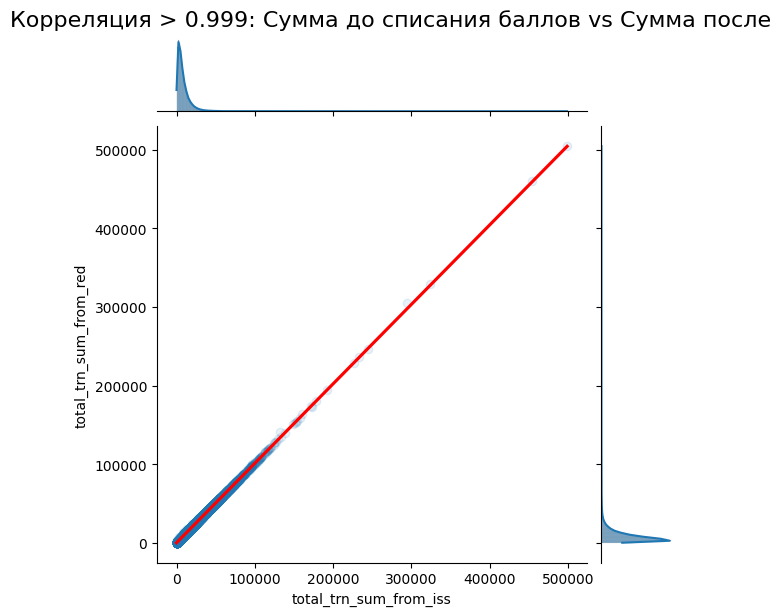

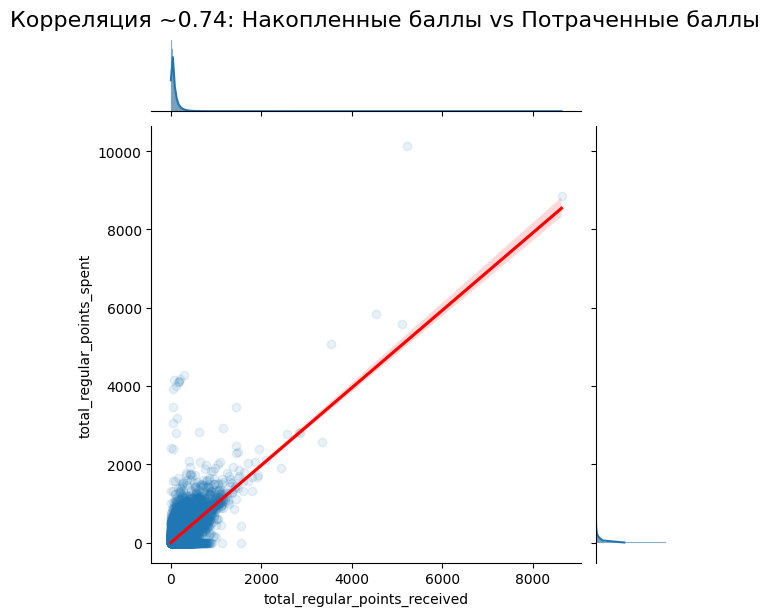

In [36]:
# Пара с самой сильной связью (почти 1.0)
# total_trn_sum_from_iss vs total_trn_sum_from_red
sns.jointplot(data=final_df_for_analysis, 
              x='total_trn_sum_from_iss', 
              y='total_trn_sum_from_red', 
              kind='reg',
              joint_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}})
plt.suptitle('Корреляция > 0.999: Сумма до списания баллов vs Сумма после', y=1.02, fontsize=16)
plt.show()


# Пара с интересной связью
# total_regular_points_received vs total_regular_points_spent
sns.jointplot(data=final_df_for_analysis, 
              x='total_regular_points_received', 
              y='total_regular_points_spent', 
              kind='reg',
              joint_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}})
plt.suptitle('Корреляция ~0.74: Накопленные баллы vs Потраченные баллы', y=1.02, fontsize=16)
plt.show()

### Выводы по анализу корреляций

На основе тепловой карты и программного поиска пар с абсолютным коэффициентом корреляции > 0.7, мы выделили несколько ключевых "кластеров" признаков и сделали некоторые выводы.

**Кластер 1: Абсолютная корреляция > 0.95**

Эта группа признаков демонстрирует почти идеальную линейную зависимость, что говорит о функциональной связи.

-   Корреляции между признаками `total_purchase_sum`, `total_trn_sum_from_iss`, `total_trn_sum_from_red` превышают 0.99. Эти признаки являются разными  измерениями общего объема трат клиента. Наиболее ценную информацию в себе несет `total_purchase_sum` - общая сумма покупки.
-   `avg_transaction_amount` и `transaction_amount_q0.75` (**0.97**), а также для `q0.5` (**0.96**). Средний чек очень сильно определяется медианой и верхним квантилем, что указывает на относительную стабильность трат у клиентов.

В дальнейшем оставлять эту группу нельзя в связи с тем, что это вызовет мультиколлинеарность, которая сломает линейную модель. Поэтому стоит выделить по одному представителю для каждой из подгрупп.

**Кластер 2: Абсолютная корреляция 0.8 - 0.95**

Эта группа обладает сильной структурной связью.

-   `total_purchase_sum` vs `total_regular_points_received` (**0.91**): Прямое отражение механики программы лояльности.
-   `total_purchase_sum` vs `total_products_purchased` (**0.93**): Клиенты, тратящие больше, покупают больше товаров.
-   `total_purchase_sum` vs `unique_products_count` (**0.86**): Покупатели с большим оборотом также имеют более широкие интересы.
-   `avg_transaction_amount` vs `avg_regular_points_per_transaction` (**0.87**): Отражение той же механики лояльности, но на уровне среднего чека.

Аналогично первой группе, эта группа также содержит высокую степень избыточности, так как признаки несут очень похожую информацию и вызывают мультиколлинеарность, хотя и не идентичны.

**Кластер 3: Абсолютная корреляция 0.7 - 0.8**

Интересный диапазон корреляций, так как связи в нем связи имеют уже поведенческий характер и могут раскрывать интересные инсайты.

-   `total_regular_points_received` vs `total_regular_points_spent` (**0.74**): Данная пара показывает, что клиенты, которые активно копят баллы, также активно их и тратят. 
-   `total_express_points_received` vs `avg_express_points_per_transaction` (**0.78**): Связь между общим количеством экспресс-баллов и их средним начислением за транзакцию.

Признаки в этой группе менее избыточны и могут в дальнейшем представлять пользу для модели. Особенно стоит обратить внимание на пару `total_regular_points_received` vs `total_regular_points_spent`, так как она несет информацию о действии списания, а не просто о накоплении, что может быть ценным для модели, несмотря на корреляцию.

Для сохранения интерпретируемости признаков, на данном этапе мы не будем пользоваться PCA, ограничившись корректировками исходя корреляционного анализа. 

Удалим два признака, дублирующие метрики баллов в отношении к товару (`total_trn_sum_from_iss` и `total_trn_sum_from_red`). Из метрик среднего чека оставим квантиль 0.5, так как он характеризует стабильность покупок клиента и их разброс. На основе среднего чека выделим меру того, сколько в среднем сохраняет стоимости покупки один бонусный балл - `avg_transaction_amount_per_point`. И выделим из метрик трат баллов общий баланс на клиента.

In [37]:
# Определим, какие бизнес-метрики мы полагаем объединить для получения новых признаков
final_df_for_analysis['total_purchase_sum_per_product'] = final_df_for_analysis['total_purchase_sum']/final_df_for_analysis['total_products_purchased']
final_df_for_analysis['total_regular_points_balance'] = final_df_for_analysis['total_regular_points_received']-final_df_for_analysis['total_regular_points_spent']
final_df_for_analysis['total_express_points_balance'] = final_df_for_analysis['total_express_points_received']-final_df_for_analysis['total_express_points_spent']
final_df_for_analysis['avg_transaction_amount_per_point'] = final_df_for_analysis['avg_transaction_amount']/final_df_for_analysis['avg_regular_points_per_transaction']
final_df_for_analysis_reducted = final_df_for_analysis.drop(
    columns = ['total_trn_sum_from_iss','total_trn_sum_from_red',
             'transaction_amount_q0.75','transaction_amount_q0.25','total_purchase_sum','total_products_purchased',
             'avg_regular_points_per_transaction','total_regular_points_received',
             'total_regular_points_spent','total_express_points_received','total_express_points_spent',
             'avg_transaction_amount','avg_regular_points_per_transaction'])

ЗДЕСЬ НУЖНО ПОСМОТРЕТЬ КОРРЕЛЯЦИЮ НЕЧИСЛОВЫХ ПРИЗНАКОВ....

# Распределение таргета по признакам и тритменту

In [39]:
def phi_binary(x: pd.Series, y: pd.Series) -> float:
    x = x.astype(float)
    y = y.astype(float)
    r = x.corr(y)
    return float(r) if pd.notna(r) else 0.0

def eta_squared_categorical(x: pd.Series, y: pd.Series) -> float:
    y = y.astype(float)
    if np.isclose(y.var(), 0.0):
        return 0.0
    means = y.groupby(x).mean()
    weights = x.value_counts(normalize=True).reindex(means.index).fillna(0.0)
    between = float(((means - y.mean())**2 * weights).sum())
    return between / float(y.var())

class TargetScore:
    """
    Сводный скор связности признаков с таргетом:
      numeric   -> |Pearson r|          in [0,1]
      binary    -> |phi (Pearson 0/1)|  in [0,1]
      categorical -> η^2 (correlation ratio) in [0,1]
    """

    def __init__(self, target_col: str, ignore_dates: bool = True,
                 min_cat_freq: float = 0.005, rare_label: str = "__RARE__"):
        self.target_col = target_col
        self.ignore_dates = ignore_dates
        self.min_cat_freq = min_cat_freq
        self.rare_label = rare_label

    def summarize(self, df: pd.DataFrame) -> pd.DataFrame:
        t = self.target_col
        assert t in df.columns, f"Нет столбца таргета: {t}"
        y = df[t].astype(float)

        features = [c for c in df.columns if c != t]
        rows = []

        for f in features:
            s = df[f]
            kind = self._kind(s)
            if kind == "datetime" and self.ignore_dates:
                continue

            if kind == "numeric":
                x = pd.to_numeric(s, errors="coerce")
                m = self._safe_corr(x, y)# [-1, 1]
                score = abs(m) if pd.notna(m) else 0.0
                rows.append({"feature": f, "kind": kind, "score": score, "sign": m, "note": "abs(Pearson)"})

            elif kind == "binary":
                r = phi_binary(s, y)# [-1, 1]
                rows.append({"feature": f, "kind": kind, "score": abs(r), "sign": r, "note": "phi (binary-binary)"})

            else:  # categorical
                x = self._collapse_rare(s)
                eta2 = eta_squared_categorical(x, y)[0, 1]
                k = int(x.nunique(dropna=True))
                rows.append({"feature": f, "kind": "categorical", "score": float(eta2), "sign": np.nan,
                             "note": f"eta^2, cats={k}"})

        out = pd.DataFrame(rows).sort_values("score", ascending=False).reset_index(drop=True)
        return out

    def plot(self, summary: pd.DataFrame, top_k: int = 30, title: str = None):
        if summary.empty:
            print("summary пуст.")
            return
        sub = summary.head(top_k).iloc[::-1]  # снизу-вверх
        palette = {"numeric": "#5B8FF9", "binary": "#5AD8A6", "categorical": "#F6BD16"}
        colors = sub["kind"].map(palette).fillna("#BFBFBF")

        plt.figure(figsize=(12, max(5, 0.45*len(sub))))
        ax = sns.barplot(x="score", y="feature", data=sub, hue="kind", dodge=False, palette=palette)
        ax.legend(title="Тип признака", loc="lower right")
        ax.set_xlabel("Сила связи с таргетом (нормированная)")
        ax.set_ylabel("")
        ax.set_xlim(0, 1)
        ax.set_title(title or f"Топ-{len(sub)} признаков по связи с таргетом")

        # подписи на барах
        for p in ax.patches:
            w = p.get_width()
            if np.isfinite(w) and w > 0:
                ax.text(w + 0.01, p.get_y() + p.get_height()/2, f"{w:.3f}", va="center", fontsize=9)

        sns.despine(left=True, bottom=True)
        plt.tight_layout()
        plt.show()

    def _kind(self, s: pd.Series) -> str:
        if pd.api.types.is_datetime64_any_dtype(s): 
            return "datetime"
        if pd.api.types.is_bool_dtype(s): 
            return "binary"
        if pd.api.types.is_numeric_dtype(s):
            vals = pd.Series(s).dropna().unique()
            if len(vals) <= 2 and set(pd.Series(vals).astype(float)) <= {0.0, 1.0}:
                return "binary"
            return "numeric"
        return "categorical"

    def _collapse_rare(self, s: pd.Series) -> pd.Series:
        vc = s.value_counts(normalize=True)
        rare = vc[vc < self.min_cat_freq].index
        if len(rare) == 0:
            return s
        x = s.astype(object).copy()
        x.loc[x.isin(rare)] = self.rare_label
        return x

    def _safe_corr(self, a: pd.Series, b: pd.Series) -> float:
        a = pd.to_numeric(a, errors="coerce").astype(float)
        b = pd.to_numeric(b, errors="coerce").astype(float)
        mask = a.notna() & b.notna()
        a, b = a[mask], b[mask]
        if a.size < 3:
            return np.nan
        if np.isclose(a.std(ddof=0), 0) or np.isclose(b.std(ddof=0), 0):
            return np.nan
        return float(a.corr(b))

In [40]:
import warnings
warnings.filterwarnings('ignore')

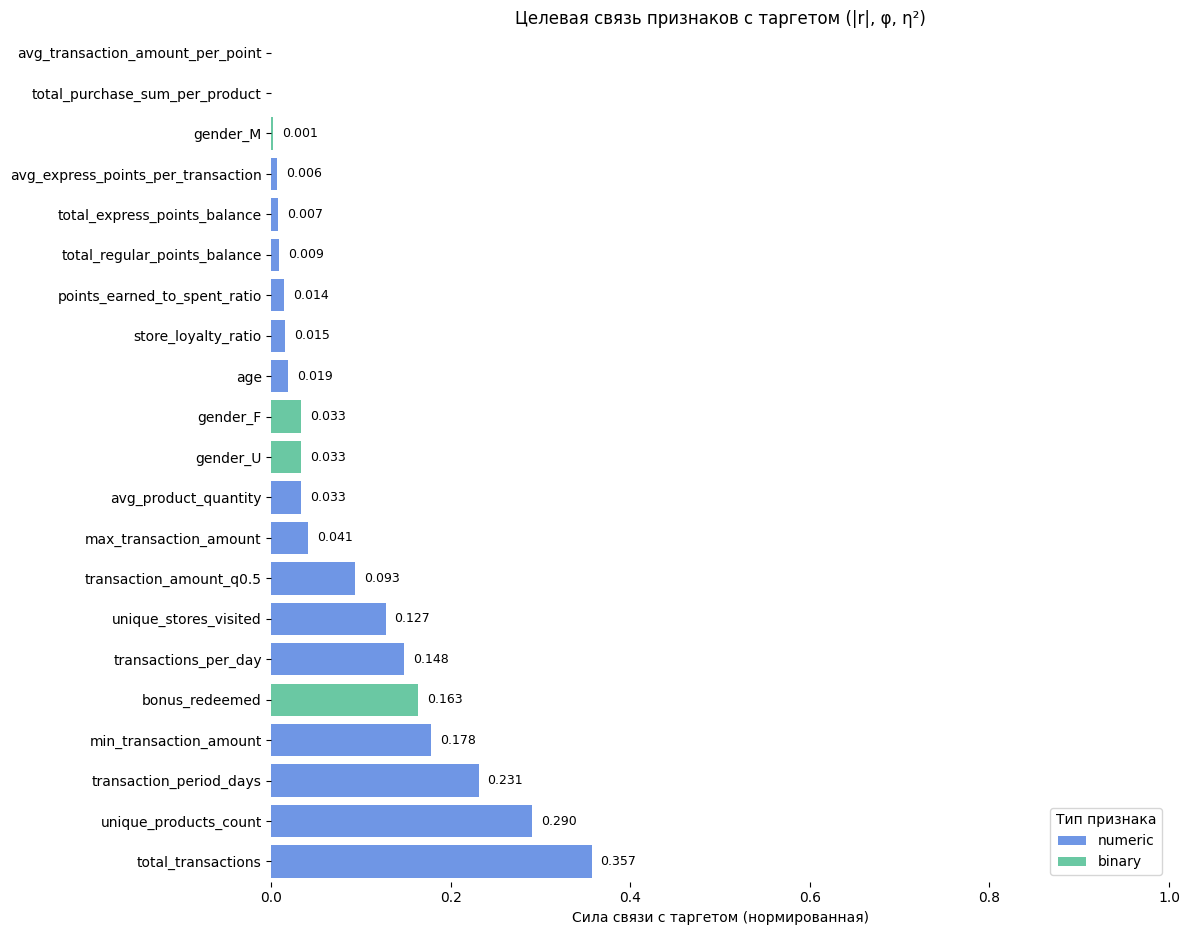

In [46]:
ts = TargetScore(target_col="target", ignore_dates=True, min_cat_freq=0.005)
summary = ts.summarize(final_df_for_analysis_reducted.drop(columns=["treatment_flg"], errors="ignore"))
ts.plot(summary, top_k=30, title="Целевая связь признаков с таргетом (|r|, φ, η²)")

In [48]:
summary

,feature,kind,score,sign,note
0,total_transactions,numeric,0.356609,0.356609,abs(Pearson)
1,unique_products_count,numeric,0.290271,0.290271,abs(Pearson)
2,transaction_period_days,numeric,0.230674,0.230674,abs(Pearson)
3,min_transaction_amount,numeric,0.178185,-0.178185,abs(Pearson)
4,bonus_redeemed,binary,0.163448,0.163448,phi (binary-binary)
5,transactions_per_day,numeric,0.148106,0.148106,abs(Pearson)
6,unique_stores_visited,numeric,0.127131,0.127131,abs(Pearson)
7,transaction_amount_q0.5,numeric,0.092721,-0.092721,abs(Pearson)
8,max_transaction_amount,numeric,0.040736,0.040736,abs(Pearson)
9,avg_product_quantity,numeric,0.033163,-0.033163,abs(Pearson)


**Полусуммарный анализ силы связи признаков с таргетом**

Анализ оценивает **силу статистической связи каждого признака с целевой переменной (`target`)**.  
Каждый признак получает числовой **score** в диапазоне `[0, 1]`, который показывает, насколько сильно он влияет на таргет:  
чем ближе значение к 1 — тем сильнее зависимость.

**Используемые метрики**

| Тип признака | Метрика | Смысл | Диапазон | Интерпретация |
|---------------|----------|--------|-----------|----------------|
| **numeric** | **(Pearson)** | Линейная корреляция признака и таргета | [0 , 1] | Показывает, растёт ли таргет при росте признака |
| **binary** | **φ (phi-коэффициент)** | То же, что Пирсон для 0/1-признаков | [0 , 1] | Насколько различаются средние значения таргета между группами 0 и 1 |
| **categorical** | **η² (eta squared)** | Доля дисперсии таргета, объяснённая категорией | [0 , 1] | Насколько категории разделяют таргет по среднему |

Все меры нормированы, поэтому их можно напрямую сравнивать между собой.


**Описание столбцов таблицы**

| Колонка | Значение |
|----------|-----------|
| **feature** | Название признака |
| **kind** | Тип признака (`numeric`, `binary`, `categorical`) |
| **score** | Абсолютная сила связи с таргетом по выбранной метрике |
| **sign** | Знак связи (только для числовых и бинарных): положительный → таргет растёт; отрицательный → снижается |
| **note** | Какая метрика использована для оценки |


**Как интерпретировать значения**

- **0.3 – 0.5 и выше** — умеренная или сильная связь → признак значим.  
- **0.1 – 0.3** — слабая, но возможная поведенческая зависимость.  
- **< 0.1** — шум или слабая корреляция, скорее всего не информативно.


**Основные наблюдения**

- **`total_transactions` (r ≈ 0.36)** — наиболее сильно связан с таргетом: чем больше покупок, тем выше вероятность целевого действия.  
- **`unique_products_count` (r ≈ 0.29)** — разнообразие товаров коррелирует с откликом.  
- **`transaction_period_days` (r ≈ 0.23)** — чем дольше период активности клиента, тем выше связь с таргетом.  
- **`min_transaction_amount` (r ≈ −0.18)** — низкий минимальный чек характерен для неоткликнувшихся.  
- **`bonus_redeemed` (φ ≈ 0.16)** — активация бонусов положительно влияет на вероятность отклика.  
- Остальные фичи имеют слабую или нулевую связь и, вероятно, будут мало информативны.

In [44]:
# Находим признаки с нулевым скором
zero_score_features = summary.loc[summary["score"] ==0, "feature"].tolist()
print(f"Признаков с нулевым score: {len(zero_score_features)}")
print(zero_score_features)
final_df_for_analysis_new = final_df_for_analysis_reducted.drop(columns=zero_score_features, errors="ignore")

Признаков с нулевым score: 2
['total_purchase_sum_per_product', 'avg_transaction_amount_per_point']


### Теперь посмотрим на распределение в группах по тритменту:

In [50]:
ts_tratment = TargetScore(target_col="target", ignore_dates=True, min_cat_freq=0.005)

# считаем силу связи для контрольной и экспериментальной групп
summary_t0 = ts_tratment.summarize(final_df_for_analysis_reducted.query("treatment_flg == 0"))
summary_t1 = ts_tratment.summarize(final_df_for_analysis_reducted.query("treatment_flg == 1"))

# объединяем результаты
compare = summary_t0[["feature", "kind", "score"]].merge(
    summary_t1[["feature", "score"]],
    on="feature",
    suffixes=("_t0", "_t1")
)

# вычисляем дельту (абсолютная разница силы связи)
compare["delta_abs"] = (compare["score_t1"] - compare["score_t0"]).abs()
compare["delta_signed"] = compare["score_t1"] - compare["score_t0"]

# сортировка по силе расхождения
compare_sorted = compare.sort_values("delta_abs", ascending=False).reset_index(drop=True)
compare_sorted

,feature,kind,score_t0,score_t1,delta_abs,delta_signed
0,unique_products_count,numeric,0.301849,0.278632,0.023216,-0.023216
1,total_transactions,numeric,0.365850,0.347462,0.018387,-0.018387
2,max_transaction_amount,numeric,0.049016,0.032235,0.016781,-0.016781
3,bonus_redeemed,binary,0.155655,0.171065,0.015411,0.015411
4,total_express_points_balance,numeric,0.025803,0.011857,0.013946,-0.013946
5,unique_stores_visited,numeric,0.133326,0.120933,0.012393,-0.012393
6,gender_F,binary,0.026750,0.038467,0.011717,0.011717
7,age,numeric,0.014156,0.025800,0.011644,0.011644
8,avg_product_quantity,numeric,0.040241,0.028958,0.011283,-0.011283
9,transaction_period_days,numeric,0.235422,0.225795,0.009627,-0.009627


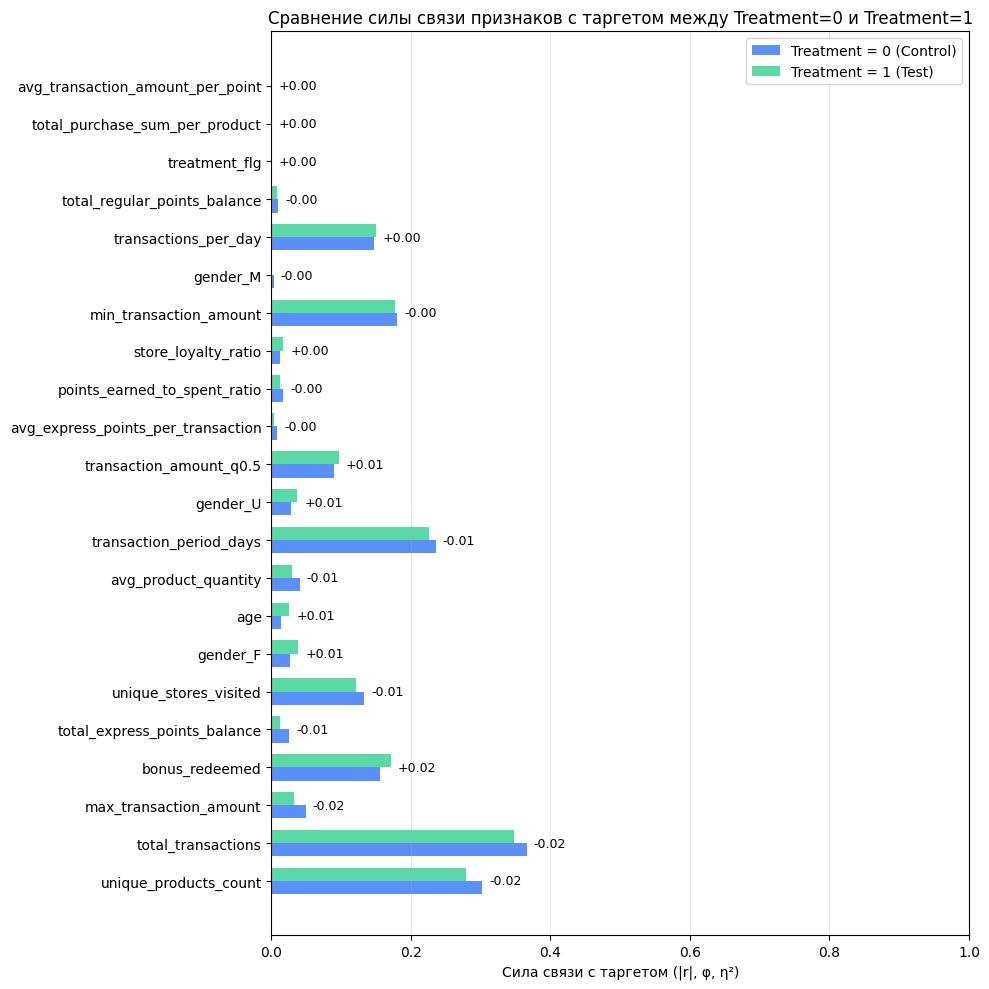

In [51]:
# Визуализация различий по тритмент-группам
plt.figure(figsize=(10, max(5, 0.5 * len(compare_sorted.head(20)))))

top = compare_sorted
bar_w = 0.35
y = np.arange(len(top))

plt.barh(y - bar_w/2, top["score_t0"], height=bar_w, color="#5B8FF9", label="Treatment = 0 (Control)")
plt.barh(y + bar_w/2, top["score_t1"], height=bar_w, color="#5AD8A6", label="Treatment = 1 (Test)")

# подсветка по дельте
for i, d in enumerate(top["delta_signed"]):
    plt.text(max(top["score_t0"][i], top["score_t1"][i]) + 0.01,
             i, f"{d:+.2f}", va="center", fontsize=9)

plt.yticks(y, top["feature"])
plt.xlabel("Сила связи с таргетом (|r|, φ, η²)")
plt.title("Сравнение силы связи признаков с таргетом между Treatment=0 и Treatment=1")
plt.xlim(0, 1)
plt.legend()
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()


**Признаков с нулевым score: 2**  

`['total_purchase_sum_per_product', 'avg_transaction_amount_per_point']`

- `total_purchase_sum_per_product = total_purchase_sum / total_products_purchased`.  
  Часто «средняя сумма на товар» оказывается очень шумной и слабо связанной с откликом (много делений на малые количества, усечения и т.п.). В сочетании с сильной корреляцией компонент (sum и qty) такой агрегат легко «схлопывается» к нулевой информативности.
- `avg_transaction_amount_per_point = avg_transaction_amount / avg_regular_points_per_transaction`.  
  Это отношение двух величин, которые уже «сидят» в сильных связях с суммами/квантилями и начислением баллов. В итоге метрика часто либо нестабильна (деление на очень малое среднее начисление), либо не добавляет новой вариации относительно уже учтённых фич.



**Сравнение по группам Treatment (0 vs 1)**

Мы посчитали **score_t0** и **score_t1** отдельно и вывели **Δ = score_t1 − score_t0**.

**Результаты:**
- Большая |Δ| → признак по-разному «ведёт себя» в control vs test → кандидат на гетерогенный эффект (полезно для uplift).  
- Знак Δ:  
  - `Δ > 0` — признак сильнее связан с таргетом в группе **Treatment=1**;  
  - `Δ < 0` — сильнее в **Treatment=0**.

- `unique_products_count`: |Δ| ≈ 0.023 — информативен в обеих группах, немного сильнее в control (Δ < 0).  
- `total_transactions`: |Δ| ≈ 0.018 — тоже в обеих группах, чуть сильнее в control.  
- `bonus_redeemed`: |Δ| ≈ +0.015 — чуть **сильнее** в treatment → поведение с бонусами лучше дифференцирует отклик под воздействием.  
- Различия ~0.01–0.02 — умеренные, но уже показывают направление потенциальной гетерогенности.



ОСТАЛОСЬ СТАТЗНАЧ ТАРГЕТА ОТ ТРИТМЕНТА И РАСПРЕДЕЛЕНИЕ ТАРГЕТА ПО ТРИТМЕНТУ

# Балансировка контрольной и таргет групп

Здесь нужно выбрать только значимые фичи, убрать мультиколлинеарность, посчитать пропенсити скор и распределения по нему, оценить сбалансированность групп

In [ ]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_auc_score
from scipy.stats import ks_2samp
from sklift.models import ClassTransformationReg

ТУТ БУДЕТ МОДЕЛЬ....